<a href="https://colab.research.google.com/github/ryanharvey1/teamA-grebes-NMA2020/blob/master/speed_cells_expanded.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Find running calcium response correlations

This script finds significant linear relationships between calcium response and running speed

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

plt.rcParams.update({'font.size': 13})
%config InlineBackend.figure_format = 'retina'
from sklearn.linear_model import LinearRegression
import sys
import pandas as pd  
import numpy as np 
from scipy import stats  
from itertools import compress
import os.path

In [ ]:
def figsize(scale):
	fig_width_pt = 483.69687                        # Get this from LaTeX using \the\textwidth
	inches_per_pt = 1.0/72.27                       # Convert pt to inch
	golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
	fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
	fig_height = fig_width*golden_mean        # height in inches
	fig_size = [fig_width,fig_height]
	return fig_size

## download data

TODO: make general for wider dataset

In [ ]:
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())        

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


## get spearman correlation

In [ ]:
def compute_correlation(speed,fr):
  speed_score,_ = stats.spearmanr(speed,fr)
  return speed_score

## get slope and intercept using linear regression

In [ ]:
def get_slope_intercept(speed,fr):

  x = speed[np.newaxis].T
  y = fr[np.newaxis].T

  model = LinearRegression()
  model.fit(x,y)

  m = model.coef_
  b = model.intercept_
  return m,b

## get speed maps 

speed maps are the mean neural response at each speed bin 

In [ ]:
def get_speed_map(speed,fr):
  # speed_vec = np.arange(min(speed),np.percentile(speed,95),2)
  speed_vec = np.arange(min(speed),max(speed),2)
  fr_speed_maps = []
  # get mean firing rate in each speed bin
  for j in range(len(speed_vec)-1):
    start = speed_vec[j]
    stop = speed_vec[j+1]

    idx = [speed > start] and [speed < stop]
    fr_speed_maps.append(np.mean(fr[tuple(idx)]))

    # sem.append(np.std(fr(idx)) / np.sqrt(len(fr(idx))))
  return fr_speed_maps

## Get speed modulation

This is generated as to control for significant tuning with a very small range

In [ ]:
def speed_modulation(speed_map):
  speed_mod = (max(speed_map) - min(speed_map)) / np.mean(speed_map)
  return np.array(speed_mod)

## shuffle speed modulation and correlation

Each cell’s response vector was shuffled by a random interval from ~20 s before or after its true position to obtain a null distribution for each cell

In [ ]:
def pvalue(shuff_dist,score):
  # DOI: 10.2202/1544-6115.1585
  return (sum(np.abs(shuff_dist) > np.abs(score)) + 1) /(len(shuff_dist) + 1)

def shuffle(speed_mod,speed_cor,speed,fr,shuffn=100,shuff_range=24):
  
  # make random vector of shuffle amounts
  r = np.random.randint(-shuff_range,shuff_range,shuffn)

  speed_mod_shuff = []
  speed_score_shuff = []

  for i in range(len(r)):
    # shuffle speed modulation
    speed_map = get_speed_map(speed,np.roll(fr,r[i]))
    speed_mod_shuff.append(speed_modulation(speed_map))

    # shuffle speed correlation
    speed_score_shuff.append(compute_correlation(speed,np.roll(fr,r[i])))

  # return p values
  return pvalue(speed_mod_shuff,speed_mod), pvalue(speed_score_shuff,speed_cor)

## run though every cell

In [ ]:
def run_all_cells(dat):
  cells,time = dat['sresp'].shape
  run = np.squeeze(dat['run'])
  X = dat['sresp']

  # speed_cor = []
  # speed_cor_pvalue = []
  # m = []
  # b = []
  # speed_map = []
  # speed_mod = []
  # speed_mod_pvalue = []
  folder = "/content/drive/My Drive/nma_data/6163622_v6/temp_data_speed_cells/" + dat2['session_name'][:-4]
  if os.path.isdir(folder)==0:
    os.mkdir(folder)

  for i in range(cells):
    if os.path.isfile(folder + "_" + str(i) + ".npy"):
      continue
    # get speed response correlation
    speed_cor = compute_correlation(run,X[i,:])
    
    # linear regression
    m, b = get_slope_intercept(run,X[i,:])

    # speed map
    speed_map = (get_speed_map(run,X[i,:]))

    # speed modulation
    speed_mod = speed_modulation(speed_map)

    # shuffle speed correlation & speed modulation
    speed_mod_pvalue, speed_cor_pvalue = shuffle(speed_mod,speed_cor,run,X[i,:])

    # update counter
    sys.stdout.write('\rcurrent cell: %d' %(cells - i))
    sys.stdout.flush()

    d={'speed_cor': speed_cor, 'speed_cor_pvalue': speed_cor_pvalue,
          'slope': m, 'intercept': b, 'speed_mod': speed_mod,
      'speed_mod_pvalue': speed_mod_pvalue, 'speed_map': speed_map}


    np.save(folder + "_" + str(i) + ".npy",d)

    # df = pd.DataFrame(d)

    # df.to_pickle("/content/drive/My Drive/nma_data/6163622_v6/temp_data_speed_cells/speed_df/" + dat['experiment'] + str(i) + ".pkl")
  # return

In [ ]:
df,speed_map,sem = run_all_cells(dat)
np.save('/content/drive/My Drive/nma_data/6163622_v6/speed_map.npy',speed_map)
df.to_pickle("/content/drive/My Drive/nma_data/6163622_v6/speed_df.pkl")

df

## If data was already ran, load it here

In [ ]:
if "speed_map" in locals():
  print('saving')
  np.save('/content/drive/My Drive/nma_data/6163622_v6/speed_map.npy',speed_map)
else:
  print('loading...')
  speed_map = np.load('/content/drive/My Drive/nma_data/6163622_v6/speed_map.npy')

if "df" in locals():
  df.to_pickle("/content/drive/My Drive/nma_data/6163622_v6/speed_df.pkl")
else:
  df = pd.read_pickle("/content/drive/My Drive/nma_data/6163622_v6/speed_df.pkl")
df

loading...


,speed_cor,speed_cor_pvalue,slope,intercept,speed_mod,speed_mod_pvalue
0,0.037081,0.031873,[[0.04655153712639664]],[6.701278006979309],0.029077431,0.059761
1,-0.015747,0.119522,[[-0.008001666373229879]],[5.433671749085655],0.010097089,0.274900
2,-0.008763,0.454183,[[-0.0073181789721904495]],[4.6965754671733455],0.010708806,0.159363
3,0.196378,0.003984,[[0.06816048084295674]],[8.474296393925272],0.16257545,0.035857
4,0.008459,0.278884,[[0.08151148078289507]],[13.27337580967431],0.009054725,0.390438
...,...,...,...,...,...,...
11978,-0.028630,0.007968,[[-0.31601890375345476]],[86.03674125511317],0.0073964316,0.561753
11979,0.009240,0.557769,[[-0.020151207141361857]],[35.48008323940126],0.024111908,0.003984
11980,-0.031522,0.031873,[[-0.010835917051686884]],[32.71565770394717],0.017061893,0.207171
11981,-0.000512,0.968127,[[-0.16513455051549225]],[53.14822019287467],0.0088076275,0.266932


## speed modulated cells

significant correlation & speed modulation score

In [ ]:
idx = (df.speed_cor_pvalue < 0.05) & (df.speed_mod_pvalue < 0.05)
print(sum(idx), ' of ', len(df),' cells')
print(np.mean(idx),' of cells are speed modulated')

2435  of  14752  cells
0.1650623644251627  of cells are speed modulated


## Figures

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


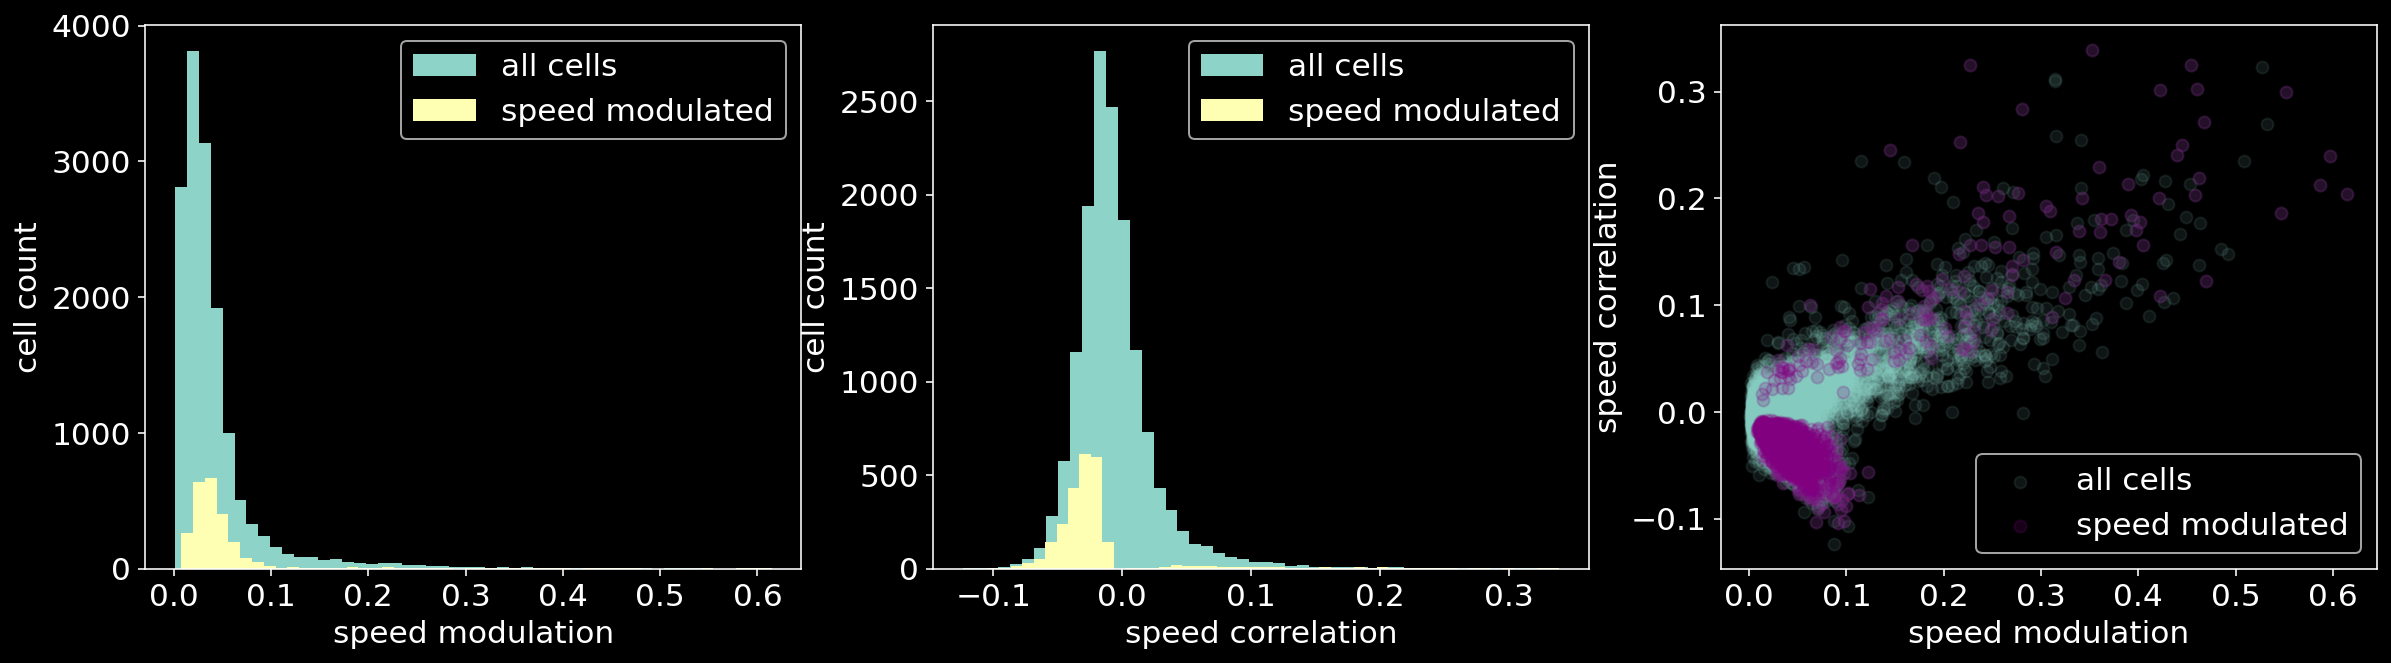

In [ ]:
idx = (df.speed_cor_pvalue < 0.05) & (df.speed_mod_pvalue < 0.05)

fig, axs = plt.subplots(1,3, figsize=(20, 5), edgecolor='k')

axs[0].hist(df.speed_mod,50,
         label='all cells')
axs[0].hist(df.speed_mod[idx],
         50,label='speed modulated')
axs[0].set_xlabel('speed modulation')
axs[0].set_ylabel('cell count')
axs[0].legend()

axs[1].hist(df.speed_cor,50,
         label='all cells')
axs[1].hist(df.speed_cor[idx],
         50,label='speed modulated')
axs[1].set_xlabel('speed correlation')
axs[1].set_ylabel('cell count')
axs[1].legend()

axs[2].scatter(df.speed_mod,df.speed_cor,label='all cells',alpha=0.1)
axs[2].scatter(df.speed_mod[idx],df.speed_cor[idx],label='speed modulated',alpha=0.2,color='purple')
axs[2].set_xlabel('speed modulation')
axs[2].set_ylabel('speed correlation')
axs[2].legend()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

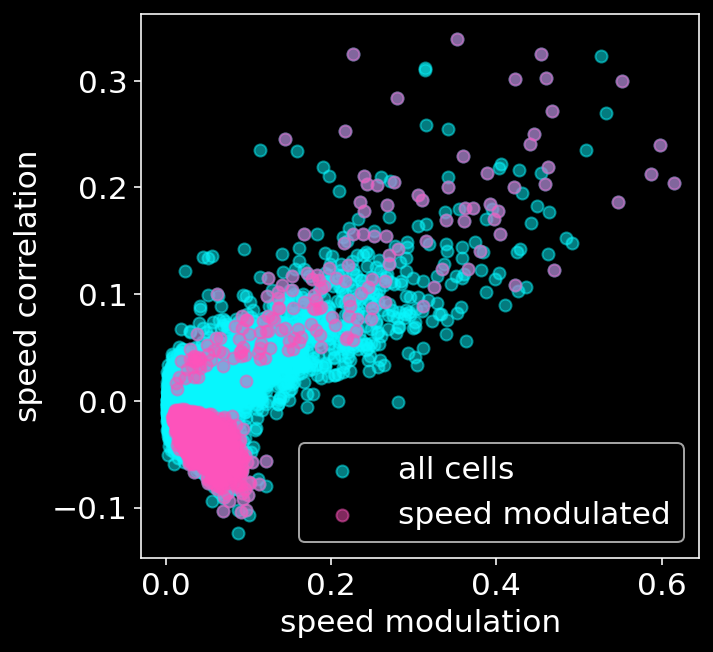

In [ ]:
fig, axs = plt.subplots(figsize=(5, 5), edgecolor='k')

axs.scatter(df.speed_mod,df.speed_cor,label='all cells',alpha=0.5,color='#08F7FE')
axs.scatter(df.speed_mod[idx],df.speed_cor[idx],label='speed modulated',alpha=0.5,color='#FE53BB')
axs.set_xlabel('speed modulation')
axs.set_ylabel('speed correlation')
axs.legend()

from google.colab import files
fig.savefig("feature_scatter.png",dpi=600,transparent=True, bbox_inches="tight")
files.download("feature_scatter.png")

## randomly display some sig speed maps

In [ ]:
sig_speed_map = list(compress(speed_map,idx))

r = np.random.randint(0,len(sig_speed_map),100)

fig, axs = plt.subplots(10,10, figsize=(20, 20), edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.5)

axs = axs.ravel()

for i in range(100):
  axs[i].plot(sig_speed_map[r[i]],linewidth=3)
  # axs[i].axis('off')
  # plt.xlabel('speed (a.u.)')
  # plt.ylabel('Calcium response')
  # plt.grid()

from google.colab import files
fig.savefig("tuning.pdf")
files.download("tuning.pdf")   

# load illuminated dataset

1 & 6 are grey

In [ ]:
# import packages
from scipy.io import loadmat
import os, fnmatch
from google.colab import drive

# mount google drive
drive.mount('/content/drive')

def find(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result

def get_dat(filenum=0,basename='/content/drive/My Drive/nma_data/6163622_v6'):
  """A def to load the spont data files

  inputs:
        filenum: 0-8 (there are 9 files)
        basename: path name to folder with data

  outputs:
        dat: dic with the same file structure from the NMA supplied file      
  """

  # find files
  files = find('*spont_*.mat',basename)

  ## clean up extra files (only keep files with spont_)
  files = [i for i in files if '/spont_' in i] 

  # load the file
  dat = loadmat(files[filenum])

  # reasign some variables to fit with other code 
  dat['sresp'] = dat.pop('Fsp')
  # dat['run'] = np.array(dat['beh']['runSpeed'][0][0])
  dat['run'] = np.array(dat['beh']['runSpeed'][0][0], dtype=np.float64)
  dat['experiment'] = dat['db'][0]['expt_name'][0][0][0][0]

  # add session name 
  dat['session_name'] = os.path.basename(files[filenum])

  return dat

dat2 = get_dat(4)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(dat2['experiment'])
print(dat2['session_name'])

spont_black
spont_M161025_MP030_2017-06-23.mat


## run all cells

In [ ]:
run_all_cells(dat2)

current cell: 7748

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in float_scalars
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarnin

current cell: 7747

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


current cell: 1

## load data from each cell

In [ ]:
folder = "/content/drive/My Drive/nma_data/6163622_v6/temp_data_speed_cells/" + dat2['session_name'][:-4]

import glob
print((folder+'*.npy'))
files = glob.glob((folder+'*.npy'))

speed_cor = []
speed_cor_pvalue = []
slope = []
speed_mod = []
speed_mod_pvalue = []
speed_map = []

for i,file in enumerate(files):

  d = np.load(file,allow_pickle=True)
  d = d.item()

  speed_cor.append(d['speed_cor'])
  speed_cor_pvalue.append(d['speed_cor_pvalue'])
  slope.append(d['slope'])
  speed_mod.append(d['speed_mod'])
  speed_mod_pvalue.append(d['speed_mod_pvalue'])
  speed_map.append(d['speed_map'])

  # update counter
  sys.stdout.write('\rcurrent cell: %d' %(len(files) - i))
  sys.stdout.flush()

/content/drive/My Drive/nma_data/6163622_v6/temp_data_speed_cells/spont_M161025_MP030_2017-06-23*.npy
current cell: 1

In [ ]:
d={'speed_cor': speed_cor, 'speed_cor_pvalue': speed_cor_pvalue,
      'slope': slope, 'speed_mod': speed_mod,'speed_mod_pvalue': speed_mod_pvalue}
df = pd.DataFrame(d)

In [ ]:
np.save('/content/drive/My Drive/nma_data/6163622_v6/spont_M161025_MP030_2017-06-23_speed_map.npy',speed_map)

df.to_pickle("/content/drive/My Drive/nma_data/6163622_v6/spont_M161025_MP030_2017-06-23.pkl")
